In [50]:
dict_args = {
  "MODEL_TYPE": "LogisticRegressionOnSimCLR",
  "model_name": "logistic_regression01",

  "encoder_path": "../trained_models/simclr01.ckpt",

  "DATA_PATH": "../../thesis01/data/",
  "data_split": [3, 1],
  "CHECKPOINT_PATH": "../checkpoints",
  "first_patient": 1,
  "num_patients_train": 100,
  "num_patients_test": 10,
  "batch_size": 64,

  "num_workers": 8,
  "lr": 1e-3,
  "weight_decay": 1e-3,
  "max_epochs": 30
}
from argparse import Namespace
args = Namespace(**dict_args)

In [51]:
import os

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from tqdm.notebook import tqdm

import constants
from datasets.SHHS_dataset_timeonly import SHHS_dataset_1, EEGdataModule

from models.logistic_regression import LogisticRegression
from models.simclr_model import CNNmodel_SimCLR
import torch
import torch.utils.data as data
from copy import deepcopy
import torch.nn as nn
import matplotlib.pyplot as plt
from utils.load_and_save_model import load_model


In [52]:
@torch.no_grad()
def prepare_data_features(model, data_loader, device):
    # Prepare model
    network = deepcopy(model.f)
    network.g = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)

    # Encode all images
    feats, labels = [], []
    for batch_inputs, batch_labels in tqdm(data_loader):
        batch_inputs = batch_inputs.to(device)
        batch_feats = network(batch_inputs.squeeze(dim=1))
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)

    return data.TensorDataset(feats, labels)

In [53]:

device = torch.device('cpu')
model = load_model(CNNmodel_SimCLR, args.encoder_path)  # Load pretrained simclr model
dm = EEGdataModule(**dict_args)  # Load datamodule
dm.setup()

Couldn't find file at path:  ../../thesis01/data/n0014_eeg.mat
Couldn't find file at path:  ../../thesis01/data/n0068_eeg.mat
Couldn't find file at path:  ../../thesis01/data/n0086_eeg.mat
Couldn't find file at path:  ../../thesis01/data/n0094_eeg.mat
Couldn't find file at path:  ../../thesis01/data/n0099_eeg.mat


In [54]:
train_ds = prepare_data_features(model, dm.train_dataloader(), device)
val_ds = prepare_data_features(model, dm.val_dataloader(), device)
test_ds = prepare_data_features(model, dm.test_dataloader(), device)

  0%|          | 0/1079 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

(array([9.391e+03, 1.070e+03, 1.148e+03, 1.134e+03, 1.032e+03, 9.850e+02,
        9.220e+02, 8.730e+02, 8.360e+02, 7.980e+02, 7.470e+02, 6.530e+02,
        6.120e+02, 5.300e+02, 4.630e+02, 3.950e+02, 3.850e+02, 3.410e+02,
        2.610e+02, 2.310e+02, 1.850e+02, 1.800e+02, 1.310e+02, 1.200e+02,
        1.010e+02, 7.600e+01, 6.600e+01, 6.200e+01, 4.700e+01, 4.200e+01,
        3.900e+01, 2.600e+01, 2.000e+01, 2.900e+01, 1.300e+01, 1.000e+01,
        1.300e+01, 9.000e+00, 7.000e+00, 5.000e+00, 2.000e+00, 3.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 2.000e+00,
        0.000e+00, 1.000e+00]),
 array([0.        , 0.0930815 , 0.18616301, 0.2792445 , 0.37232602,
        0.46540752, 0.558489  , 0.6515705 , 0.74465203, 0.8377335 ,
        0.93081504, 1.0238966 , 1.116978  , 1.2100595 , 1.303141  ,
        1.3962226 , 1.4893041 , 1.5823855 , 1.675467  , 1.7685486 ,
        1.8616301 , 1.9547116 , 2.0477931 , 2.1408746 , 2.233956  ,
        2.3270376 , 2.420119  , 2.51

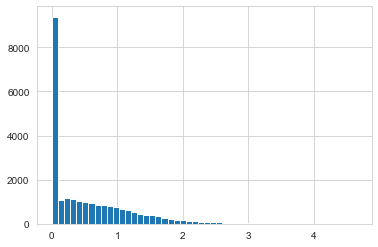

In [55]:
import matplotlib.pyplot as plt
import numpy as np
feature = train_ds.__getitem__(0)[0]
plt.hist(np.asarray(feature), bins=50)

In [56]:
sum(feature < 0.2)/feature.size(0)

tensor(0.4433)

In [62]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
tsne = TSNE(n_components=2, n_iter=300, verbose=1)
x, y = train_ds.tensors
tsne_results = tsne.fit_transform(x)

C:\Users\tomsm\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\tomsm\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 69024 samples in 1.820s...
[t-SNE] Computed neighbors for 69024 samples in 1377.400s...
[t-SNE] Computed conditional probabilities for sample 1000 / 69024
[t-SNE] Computed conditional probabilities for sample 2000 / 69024
[t-SNE] Computed conditional probabilities for sample 3000 / 69024
[t-SNE] Computed conditional probabilities for sample 4000 / 69024
[t-SNE] Computed conditional probabilities for sample 5000 / 69024
[t-SNE] Computed conditional probabilities for sample 6000 / 69024
[t-SNE] Computed conditional probabilities for sample 7000 / 69024
[t-SNE] Computed conditional probabilities for sample 8000 / 69024
[t-SNE] Computed conditional probabilities for sample 9000 / 69024
[t-SNE] Computed conditional probabilities for sample 10000 / 69024
[t-SNE] Computed conditional probabilities for sample 11000 / 69024
[t-SNE] Computed conditional probabilities for sample 12000 / 69024
[t-SNE] Computed conditional probabilities for 

<AxesSubplot:xlabel='comp-1', ylabel='comp-2'>

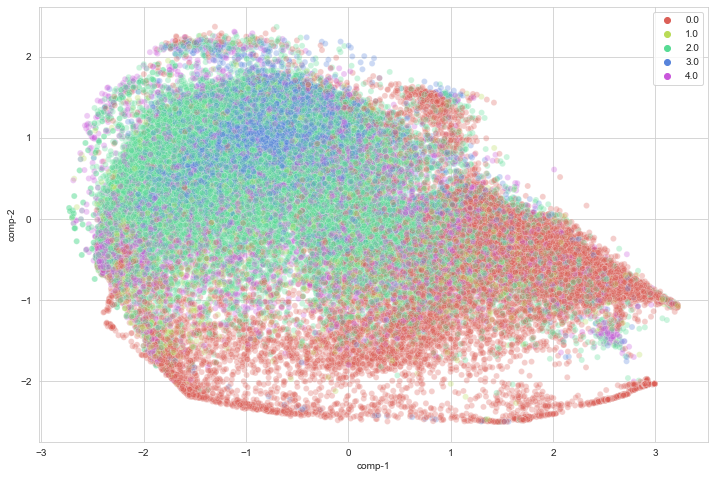

In [63]:
df = pd.DataFrame()
df['comp-1'] = tsne_results[:,0]
df['comp-2'] = tsne_results[:,1]
df["y"] = y
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x="comp-1", y="comp-2",
    hue=df.y.tolist(),
    palette=sns.color_palette("hls", 5),
    data=df,
    legend="full",
    alpha=0.3
)

In [57]:
trainer = pl.Trainer(default_root_dir=os.path.join(args.CHECKPOINT_PATH, "LogisticRegression"),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=args.max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc'),
                                    LearningRateMonitor("epoch")],
                         enable_progress_bar=True,
                         check_val_every_n_epoch=2)
trainer.logger._default_hp_metric = None

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [58]:
train_loader = data.DataLoader(train_ds, batch_size=args.batch_size, shuffle=True,
                                   drop_last=False, pin_memory=True, num_workers=args.num_workers)
val_loader = data.DataLoader(val_ds, batch_size=args.batch_size, shuffle=True,
                                 drop_last=False, pin_memory=True, num_workers=args.num_workers)
test_loader = data.DataLoader(test_ds, batch_size=args.batch_size, shuffle=False,
                                  drop_last=False, pin_memory=True, num_workers=args.num_workers)

In [59]:
log_model = LogisticRegression(feature_dim=int(constants.SLEEP_EPOCH_SIZE/8*model.hparams.model_hparams['conv_filters'][-1]), **dict_args)

In [60]:
trainer.fit(log_model, train_loader, val_loader)


  | Name  | Type   | Params
---------------------------------
0 | model | Linear | 120 K 
---------------------------------
120 K     Trainable params
0         Non-trainable params
120 K     Total params
0.480     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\tomsm\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:489: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


In [61]:
print(trainer.checkpoint_callback.best_model_path)
model = LogisticRegression.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
test_result = trainer.test(model, test_loader, verbose=False)
print(test_result)

..\checkpoints\LogisticRegression\lightning_logs\version_9\checkpoints\epoch=9-step=10790.ckpt


Testing: 0it [00:00, ?it/s]

[{'test_loss': 2.421315908432007, 'test_acc': 0.4781542718410492}]
